### Labeling File Upload to S3

In [2]:
%cd /root/MZC_Yubin/Posco
## 이미지 파일 업로드 PATH : [버킷] - [버전] - [images]
!aws s3 cp images s3://posco-ground-truth/version_1/images --recursive

/root/MZC_Yubin/Posco
upload: images/000000000081.jpg to s3://posco-ground-truth/version_1/images/000000000081.jpg
upload: images/cat.jpg to s3://posco-ground-truth/version_1/images/cat.jpg


### Data Labeling using Ground Truth - Auto Saving to S3

https://aws.amazon.com/ko/blogs/machine-learning/streamlining-data-labeling-for-yolo-object-detection-in-amazon-sagemaker-ground-truth/

#### - Input json

In [3]:
# ground-truth-data-labeling (버킷 명)
# |-- bounding_box (폴더 이름)
#     |-- ground_truth_annots
#     |-- images (이미지 저장 위치)
#     |-- yolo_annot_files (output 폴더)
#     |-- manifest.json (manifest file)

In [4]:
# {
#     "s3_bucket":"ground-truth-data-labeling",
#     "job_id":"bounding_box",
#     "ground_truth_job_name":"yolo-bbox",
#     "yolo_output_dir":"yolo_annot_files"
# }

In [9]:
input_json = {
    "s3_bucket":"posco-ground-truth", ## 버킷 명
    "job_id":"version_1", ## Ground Truth 작업 폴더    
    "ground_truth_job_name":"gt-version-2",  ## Ground Truth job 이름
    "yolo_output_dir":"labels" ## Ground Truth txt 저장 위치 폴더
}

#### - Make manifest

In [22]:
import boto3
import json

def create_manifest(job_path):   
    s3_rec = boto3.resource("s3")
    s3_bucket = job_path.split("/")[0]
    prefix = job_path.replace(s3_bucket, "")[1:]
    image_folder = f"{prefix}/images"
    bucket = s3_rec.Bucket(s3_bucket)
    img_files = list(bucket.objects.filter(Prefix=image_folder))
    n_imgs = len(img_files)
    TOKEN = "source-ref"
    manifest_file = "/tmp/manifest.json"
    cnt = 0
    with open(manifest_file, "w") as fout:
        for img_file in img_files:
            if '.jpg' in img_file.key:
                fname = f"s3://{s3_bucket}/{img_file.key}"
                fout.write(f'{{"{TOKEN}": "{fname}"}}\n')
                cnt += 1
    print(f'{cnt} jpg file manifest')
    return manifest_file

def upload_manifest(job_path, manifest_file):
    s3_rec = boto3.resource("s3")
    s3_bucket = job_path.split("/")[0]
    source = manifest_file.split("/")[-1]
    prefix = job_path.replace(s3_bucket, "")[1:]
    destination = f"{prefix}/{source}"
    print(f"uploading manifest file to {destination} \n")
    s3_rec.meta.client.upload_file(manifest_file, s3_bucket, destination)

def main():
    input_dict = input_json.copy()

    s3_bucket = input_dict["s3_bucket"]
    job_id = input_dict["job_id"]

    gt_job_path = f"{s3_bucket}/{job_id}"
    man_file = create_manifest(gt_job_path)
    upload_manifest(gt_job_path, man_file)


if __name__ == "__main__":
    main()

2 jpg file manifest
uploading manifest file to version_1/manifest.json 



#### - Data Labeling

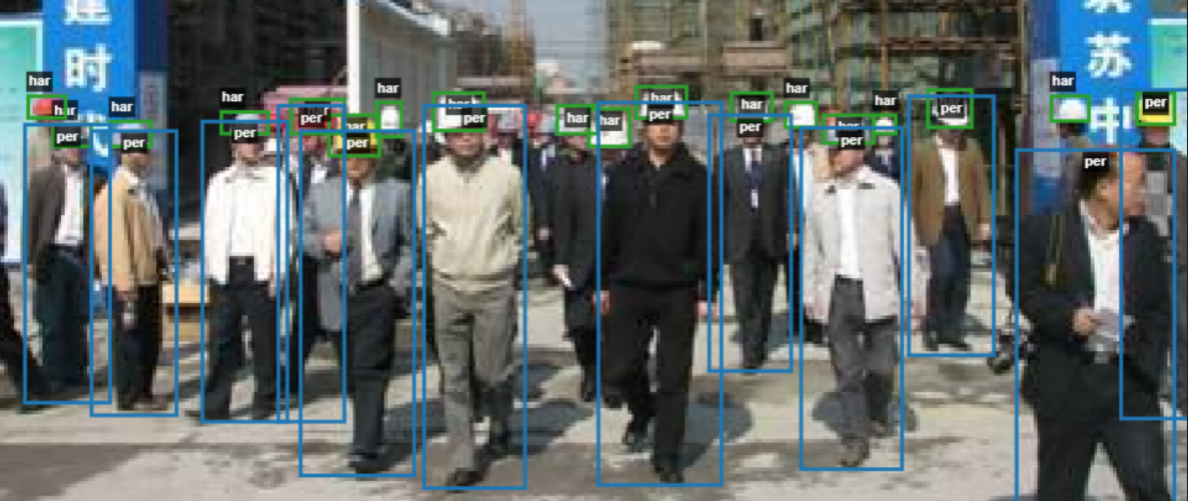

#### - Change File Format

In [2]:
from io import StringIO
import json
import s3fs
import boto3
import pandas as pd

def parse_gt_output(manifest_path, job_name):
    filesys = s3fs.S3FileSystem()
    with filesys.open(manifest_path) as fin:
        annot_list = []
        for line in fin.readlines():
            record = json.loads(line)
            if job_name in record.keys():  # is it necessary?
                image_file_path = record["source-ref"]
                image_file_name = image_file_path.split("/")[-1]
                class_maps = record[f"{job_name}-metadata"]["class-map"]

                imsize_list = record[job_name]["image_size"]
                assert len(imsize_list) == 1
                image_width = imsize_list[0]["width"]
                image_height = imsize_list[0]["height"]

                for annot in record[job_name]["annotations"]:
                    left = annot["left"]
                    top = annot["top"]
                    height = annot["height"]
                    width = annot["width"]
                    class_name = class_maps[f'{annot["class_id"]}']

                    annot_list.append(
                        [
                            image_file_name,
                            class_name,
                            left,
                            top,
                            height,
                            width,
                            image_width,
                            image_height,
                        ]
                    )

        df_bbox = pd.DataFrame(
            annot_list,
            columns=[
                "img_file",
                "category",
                "box_left",
                "box_top",
                "box_height",
                "box_width",
                "img_width",
                "img_height",
            ],
        )

    return df_bbox


def save_df_to_s3(df_local, s3_bucket, destination):
    csv_buffer = StringIO()
    s3_resource = boto3.resource("s3")

    df_local.to_csv(csv_buffer, index=False)
    s3_resource.Object(s3_bucket, destination).put(Body=csv_buffer.getvalue())


def main():
    input_dict = input_json
    s3_bucket = input_dict["s3_bucket"]
    job_id = input_dict["job_id"]
    gt_job_name = input_dict["ground_truth_job_name"]

    mani_path = f"s3://{s3_bucket}/{job_id}/labels/{gt_job_name}/manifests/output/output.manifest"

    df_annot = parse_gt_output(mani_path, gt_job_name)
    dest = f"{job_id}/ground_truth_annots/{gt_job_name}/annot.csv"
    save_df_to_s3(df_annot, s3_bucket, dest)


if __name__ == "__main__":
    main()

### Labeled Json File Load

In [33]:
!aws s3 cp s3://posco-test-bucket/bounding_box/ground_truth_annots/yolo-bbox/annot.csv /root/MZC_Yubin/Object_Detection/ground_truth

download: s3://posco-test-bucket/bounding_box/ground_truth_annots/yolo-bbox/annot.csv to ../ground_truth/annot.csv


In [35]:
import pandas as pd
df_ann = pd.read_csv('/root/MZC_Yubin/Object_Detection/ground_truth/annot.csv')
df_ann.head()

,img_file,category,box_left,box_top,box_height,box_width,img_width,img_height
0,000008_jpg.rf.RI12NshdnwtfjGf1rRcX.jpg,hard_hat,293,423,63,67,500,666
1,000008_jpg.rf.RI12NshdnwtfjGf1rRcX.jpg,hard_hat,314,394,36,42,500,666
2,000008_jpg.rf.RI12NshdnwtfjGf1rRcX.jpg,hard_hat,333,370,36,44,500,666
3,000008_jpg.rf.RI12NshdnwtfjGf1rRcX.jpg,hard_hat,216,371,37,50,500,666
4,000008_jpg.rf.RI12NshdnwtfjGf1rRcX.jpg,hard_hat,244,182,41,43,500,666


* YOLO 형식에서 각 경계 상자는 상자의 중심 좌표와 너비 및 높이로 설명됩니다.
* 각 숫자는 이미지의 크기에 따라 조정됩니다.
* 따라서 그들은 모두 0과 1 사이의 범위입니다.
* 범주 이름 대신 YOLO 모델은 해당하는 정수 범주를 기대합니다.

### Change format as Yolov5 Train Format

In [39]:
import os
import json
from io import StringIO
import boto3
import s3fs
import pandas as pd


def annot_yolo(annot_file, cats):
    """
    Prepares the annotation in YOLO format

    Input:
    annot_file: csv file containing Ground Truth annotations
    ordered_cats: List of object categories in proper order for model training

    Returns:
    df_ann: pandas dataframe with the following columns
            img_file int_category box_center_w box_center_h box_width box_height


    Note:
    YOLO data format: <object-class> <x_center> <y_center> <width> <height>
    """

    df_ann = pd.read_csv(annot_file)

    df_ann["int_category"] = df_ann["category"].apply(lambda x: cats.index(x))
    df_ann["box_center_w"] = df_ann["box_left"] + df_ann["box_width"] / 2
    df_ann["box_center_h"] = df_ann["box_top"] + df_ann["box_height"] / 2

    # scale box dimensions by image dimensions
    df_ann["box_center_w"] = df_ann["box_center_w"] / df_ann["img_width"]
    df_ann["box_center_h"] = df_ann["box_center_h"] / df_ann["img_height"]
    df_ann["box_width"] = df_ann["box_width"] / df_ann["img_width"]
    df_ann["box_height"] = df_ann["box_height"] / df_ann["img_height"]

    return df_ann


def save_annots_to_s3(s3_bucket, prefix, df_local):
    """
    For every image in the dataset, save a text file with annotation in YOLO format

    Input:
    s3_bucket: S3 bucket name
    prefix: Folder name under s3_bucket where files will be written
    df_local: pandas dataframe with the following columns
              img_file int_category box_center_w box_center_h box_width box_height
    """

    unique_images = df_local["img_file"].unique()
    s3_resource = boto3.resource("s3")

    for image_file in unique_images:
        df_single_img_annots = df_local.loc[df_local.img_file == image_file]
        annot_txt_file = image_file.split(".")[0] + ".txt"
        destination = f"{prefix}/{annot_txt_file}"

        csv_buffer = StringIO()
        df_single_img_annots.to_csv(
            csv_buffer,
            index=False,
            header=False,
            sep=" ",
            float_format="%.4f",
            columns=[
                "int_category",
                "box_center_w",
                "box_center_h",
                "box_width",
                "box_height",
            ],
        )
        s3_resource.Object(s3_bucket, destination).put(Body=csv_buffer.getvalue())


def get_cats(json_file):
    """
    Makes a list of the category names in proper order

    Input:
    json_file: s3 path of the json file containing the category information

    Returns:
    cats: List of category names
    """

    filesys = s3fs.S3FileSystem()
    with filesys.open(json_file) as fin:
        line = fin.readline()
        record = json.loads(line)
        labels = [item["label"] for item in record["labels"]]

    return labels


def main():
    """
    Performs the following tasks:
    1. Reads input from 'input.json'
    2. Collect the category names from the Ground Truth job
    3. Creates a dataframe with annotaion in YOLO format
    4. Saves a text file in S3 with YOLO annotations
       for each of the labeled images
    """

    with open("/root/MZC_Yubin/Object_Detection/ground_truth/input.json") as fjson:
        input_dict = json.load(fjson)

    s3_bucket = input_dict["s3_bucket"]
    job_id = input_dict["job_id"]
    gt_job_name = input_dict["ground_truth_job_name"]
    yolo_output = input_dict["yolo_output_dir"]

    s3_path_cats = (
        f"s3://{s3_bucket}/{job_id}/ground_truth_annots/{gt_job_name}/annotation-tool/data.json"
    )
    categories = get_cats(s3_path_cats)
    print("\n labels used in Ground Truth job: ")
    print(categories, "\n")

    gt_annot_file = "/root/MZC_Yubin/Object_Detection/ground_truth/annot.csv"
    s3_dir = f"{job_id}/{yolo_output}"
    print(f"annotation files saved in = ", s3_dir)

    df_annot = annot_yolo(gt_annot_file, categories)
    save_annots_to_s3(s3_bucket, s3_dir, df_annot)


if __name__ == "__main__":
    main()


 labels used in Ground Truth job: 
['person', 'hard_hat'] 

annotation files saved in =  bounding_box/yolo_annot_files


### Check Labeled Data

In [99]:
## load label txt 
!aws s3 cp s3://posco-test-bucket/bounding_box/yolo_annot_files/000008_jpg.txt /root/MZC_Yubin/Object_Detection/ground_truth

download: s3://posco-test-bucket/bounding_box/yolo_annot_files/000008_jpg.txt to ../ground_truth/000008_jpg.txt


In [100]:
## check label num
!aws s3 cp s3://posco-test-bucket/bounding_box/ground_truth_annots/yolo-bbox/annotation-tool/data.json /root/MZC_Yubin/Object_Detection/ground_truth

download: s3://posco-test-bucket/bounding_box/ground_truth_annots/yolo-bbox/annotation-tool/data.json to ../ground_truth/data.json


In [101]:
## load img
!aws s3 cp s3://posco-test-bucket/bounding_box/images/000008_jpg.rf.RI12NshdnwtfjGf1rRcX.jpg /root/MZC_Yubin/Object_Detection/ground_truth

download: s3://posco-test-bucket/bounding_box/images/000008_jpg.rf.RI12NshdnwtfjGf1rRcX.jpg to ../ground_truth/000008_jpg.rf.RI12NshdnwtfjGf1rRcX.jpg


In [ ]:
!pip install opencv-python-headless
import cv2

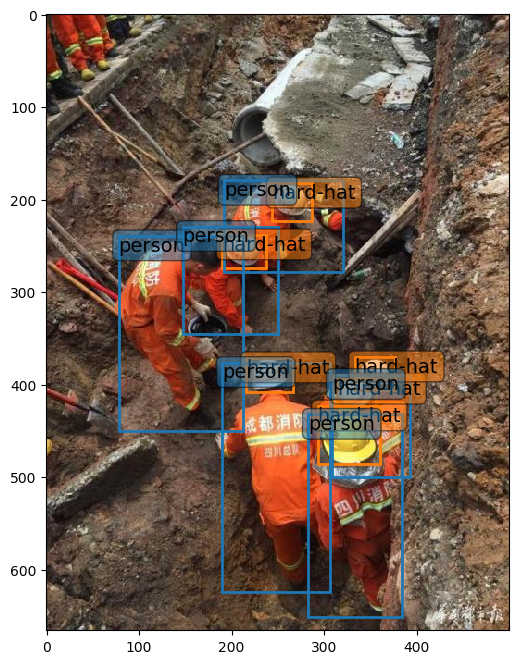

In [102]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import argparse

def visualize_bbox(img_file, yolo_ann_file, label_dict, figure_size=(6, 8)):
    img = mpimg.imread(img_file)
    fig, ax = plt.subplots(1, 1, figsize=figure_size)
    ax.imshow(img)

    im_height, im_width, _ = img.shape

    palette = mcolors.TABLEAU_COLORS
    colors = [c for c in palette.keys()]
    with open(yolo_ann_file, "r") as fin:
        for line in fin:
            cat, center_w, center_h, width, height = line.split()
            cat = int(cat)
            category_name = label_dict[cat]
            left = (float(center_w) - float(width) / 2) * im_width
            top = (float(center_h) - float(height) / 2) * im_height
            width = float(width) * im_width
            height = float(height) * im_height

            rect = plt.Rectangle(
                (left, top),
                width,
                height,
                fill=False,
                linewidth=2,
                edgecolor=colors[cat],
            )
            ax.add_patch(rect)
            props = dict(boxstyle="round", facecolor=colors[cat], alpha=0.5)
            ax.text(
                left,
                top,
                category_name,
                fontsize=14,
                verticalalignment="top",
                bbox=props,
            ) 
    plt.show()
    
labels = {0: "person", 1: "hard-hat"}
img_file = '/root/MZC_Yubin/Object_Detection/ground_truth/test.jpg'
ann_file = img_file.split(".")[0] + ".txt"

visualize_bbox(img_file, ann_file, labels, figure_size=(6, 8))

### Make Training Dataset Directory

In [174]:
!mkdir /root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat
!mkdir /root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat/images
!mkdir /root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat/labels

In [175]:
!aws s3 cp s3://posco-test-bucket/bounding_box/yolo_annot_files/ /root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat/labels --recursive
!aws s3 cp s3://posco-test-bucket/bounding_box/images/ /root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat/images --recursive

download: s3://posco-test-bucket/bounding_box/yolo_annot_files/000008_jpg.txt to coco128nHard-hat/labels/000008_jpg.txt
download: s3://posco-test-bucket/bounding_box/yolo_annot_files/000011_jpg.txt to coco128nHard-hat/labels/000011_jpg.txt
download: s3://posco-test-bucket/bounding_box/yolo_annot_files/000034_jpg.txt to coco128nHard-hat/labels/000034_jpg.txt
download: s3://posco-test-bucket/bounding_box/yolo_annot_files/000098_jpg.txt to coco128nHard-hat/labels/000098_jpg.txt
download: s3://posco-test-bucket/bounding_box/yolo_annot_files/000054_jpg.txt to coco128nHard-hat/labels/000054_jpg.txt
download: s3://posco-test-bucket/bounding_box/yolo_annot_files/000084_jpg.txt to coco128nHard-hat/labels/000084_jpg.txt
download: s3://posco-test-bucket/bounding_box/yolo_annot_files/000047_jpg.txt to coco128nHard-hat/labels/000047_jpg.txt
download: s3://posco-test-bucket/bounding_box/yolo_annot_files/000097_jpg.txt to coco128nHard-hat/labels/000097_jpg.txt
download: s3://posco-test-bucket/boundin

#### Option (image랑 label 이름이 달라서 바꾸기..)

In [176]:
img_list = os.listdir('/root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat/images')
for i in img_list:
    os.renames(f'/root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat/images/{i}', 
               f'/root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat/images/{".".join([i.split(".")[0], i.split(".")[-1]])}')    

#### - Change Hard-hat Label Num as COCO Type

In [27]:
## Label Dictionary

custom_list = ['person', 'hard-hat']
coco_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
             'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
             'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
             'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
             'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
             'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
             'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
             'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
             'hair drier', 'toothbrush']
diff_list = list(set(custom_list) - set(coco_list))
combine_list = coco_list.copy()

for i in diff_list:
    combine_list.append(i)
    
custom_dict = {string : i for i,string in enumerate(custom_list)}
label_dict = {string : i for i,string in enumerate(combine_list)}

print(custom_dict['hard-hat'])
print(label_dict['hard-hat'])
# print(list(label_dict.keys())[61])

1
80


In [28]:
# custom_dict
custom_dict = dict(map(reversed,custom_dict.items()))
## {0: 'person', 1: 'hard-hat'}
custom_dict

{0: 'person', 1: 'hard-hat'}

In [29]:
from os.path import isfile, join

custom_label_path = '/root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat/labels'
custom_label_file = [f for f in os.listdir(custom_label_path) if isfile(join(custom_label_path, f))]

In [20]:
import numpy as np

for file_name in custom_label_file:
    lst = []
    with open(f'{custom_label_path}/{file_name}') as small_pf:
        ## text file 엔터 없이 읽기
        tmp_list = []
        for line in small_pf:
            line = line.rstrip("\n")  
            if line == "":
                lst.append(tmp_list)
                tmp_list = []
            else:
                tmp_list.extend(line.split())
        if tmp_list:  # add last one
            lst.append(tmp_list)

        ## 형변환 후 DF로 변경        
        temp_array = np.array(lst)
        temp_df = pd.DataFrame(columns = ['label','x','y','width','height'], data = np.reshape(temp_array, (-1,5)))
        ## 기존 Label과 index 맞추기 위해 변경
        temp_df['label'] = temp_df['label'].astype('int')
        temp_df['label'].replace(custom_dict, inplace =True)        
        temp_df['label'].replace(label_dict, inplace = True)
        temp_df['label'] = temp_df['label'].astype('str')

        # 형변환
        result_array = np.reshape(np.array(temp_df),(1,-1)).tolist()
        result_list = []
        for i in range(int(len(result_array[0])/5)):
            result_list.append(' '.join(result_array[0][i*5:(i+1)*5]))

    with open(f'{custom_label_path}/{file_name}', 'w') as f:
        for line in result_list:
            f.write(line)
            f.write('\n')

#### - Combine Tow Data Set

In [22]:
!cp /root/MZC_Yubin/Object_Detection/datasets/coco128/images/train2017/* /root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat/images

In [23]:
!cp /root/MZC_Yubin/Object_Detection/datasets/coco128/labels/train2017/* /root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat/labels

In [32]:
len(combine_list)

81

In [33]:
#### 아래 파일 yaml로 저장

In [34]:
path : /usr/src/dataset/custom_data
train: images  
val: images

# Classes
nc: 81
names: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
        'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
        'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
        'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
        'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant',
        'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
        'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hard-hat']  # class names


# Download script/URL (optional)
# download: https://ultralytics.com/assets/coco128.zip

SyntaxError: invalid syntax (<ipython-input-34-a5a7cdcbb2e8>, line 1)

In [37]:
!pwd

/root/MZC_Yubin/Object_Detection


In [36]:
!tar -zcvf coco128nHard-hat.tar.gz /root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat

tar: Removing leading `/' from member names
/root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat/
/root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat/.ipynb_checkpoints/
/root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat/.ipynb_checkpoints/custom_data-checkpoint.yaml
/root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat/images/
/root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat/images/000000000584.jpg
/root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat/images/000098_jpg.jpg
/root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat/images/000000000629.jpg
/root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat/images/000000000368.jpg
/root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat/images/000000000089.jpg
/root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat/images/000000000359.jpg
/root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat/images/000000000395.jpg
/root/MZC_Yubin/Object_Detection/datasets/coco128nHard-hat/images

### 나머진 Jupyter Notebook에서~~

In [ ]:
import boto3

account_id = boto3.client('sts').get_caller_identity().get('Account')
ecr_repository = 'test_image'
tag = ':latest'

region = boto3.session.Session().region_name

uri_suffix = 'amazonaws.com'
if region in ['cn-north-1', 'cn-northwest-1']:
    uri_suffix = 'amazonaws.com.cn'

byoc_image_uri = '{}.dkr.ecr.{}.{}/{}'.format(account_id, region, uri_suffix, ecr_repository + tag)

byoc_image_uri
# This should return something like
# 111122223333.dkr.ecr.us-east-2.amazonaws.com/sagemaker-byoc-test:latest

In [ ]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator

estimator = Estimator(image_uri=byoc_image_uri,
                      role=get_execution_role(),
                      base_job_name='tf-custom-container-test-job',
                      instance_count=1,
                      instance_type='ml.g4dn.xlarge',
                      use_spot_instances=True,
                      max_wait=360000,
                      max_run=100000
                     )

# start training
estimator.fit()